<a href="https://colab.research.google.com/github/gekoramy/uni.deep-learning/blob/final-report/238746_240074.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning Assignment 2023
## From words to bounding boxes: exploring visual grounding using CLIP

### Luca Mosetti
*   238746
*   luca.mosetti-1@studenti.unitn.it

### Stefano Genetti
*   240074
*   stefano.genetti@studenti.unitn.it


## Abstract

Visual grounding involves linking language and perception by grounding linguistic symbols in the visual world. More in depth, in this work we face the problem usually referred to by the literature as *Referring expression comprehension* (REC). In this context the overall goal is to localize a target object in an image described by a referring expression phrased in natural language. In order to accomplish this challenging task we rely on the CLIP (*Contrastive Language-Image Pre-training*) [2] pre-trained model as a starting point for transfer learning. The capabilities of this foundation model pose a starting point to design a joint embedding approach to solve the problem at hand. In this report we provide an overview of the strategies which we have adopted in order to fine-tune CLIP for the task under discussion. We have evaluated our proposed models on the commonly used RefCOCOg dataset [3]. In addition to this, our contribution is to provide three useful instances of the dataset filled with the bounding boxes proposed by some well known  object detection algorithms. As further explained in the following of this report this solution allows to considerably speed up the training procedure. We conveniently  provide these datasets together with the code to generate them at the following GitHub repository: todo: link-repo. Furthermore, in the present notebook we alternate the text cells with code cells incorporating the implemented code.

## Introduction

Language and vision are closely related in daily life. We naturally use verbal descriptions in our conversations to refer to the objects in a given scene. Although such an activity is straightforward for the human being, the task of referring expression comprehension remains challenging for a software agent which has to bridge computer vision and natural language processing in order to achieve a comprehensive understanding of complex language semantics and various types of visual information. The problem has been receiving increasing attention from both academia and industry due to its great potential in vision-and-language navigation [1] and natural human-computer interaction. The aim of our work is to train a model which takes as input an image and a natural language prompt and outputs a single bounding box which corresponds to the entity referred to in the textual description (Figure 1).

Formula input -> output
\begin{equation}
    f: I \times P \rightarrow B
\end{equation}

According to the literature, the most common methods to tackle the task at hand are based on the encoding of image regions and expressions into the same vector space [4]. To this end we adopt the CLIP (Contrastive Language-Image Pre-training) [2] model as a foundation model for our framework. This strategy allows us to take advantage of a powerful model pre-trained with massive computational resources and consequently reduce the amount of power that we need to obtain meaningful results. Clearly, visual grounding is not the original purpose of CLIP. Consequently, we need to perform transfer learning in order to fine-tune the original model to build a customized one that excels in our downstream task. In this paper we provide a detailed overview of the solutions that we have studied to solve the problem. To this end we have trained and evaluated several model architectures according to the metrics commonly suggested by the literature, on the RefCOCOg dataset [3], a variant of the Referring Expression Generation (REG) dataset, which is particularly suitable in our case. For each implemented model we report the obtained performances bringing to light its strengths and weaknesses. A methodological comparison of the proposed architecture designs has allowed us to select the most promising implementation. As outlined at the end of this document, the final model has been further refined in an attempt to improve its generalization capabilities. The overall goal of this work is not to achieve state of the art performances. Rather, our contribution is to suggest original solutions to tackle the problem and highlight promising directions which should be further investigated with stronger hardware capabilities. In this regard, throughout the report we strain our attention on several valuable strategies which have been adopted in order to deal with limited time and computational resources. The notebook is organized as follows.
*   At the beginning we provide a brief overview of the related works proposed by the literature over the years to face similar challenges.
*   Then, we explain the peculiarities of our reference dataset. There is no predefined dataset class appropriate for the visual grounding task. Hence, we describe how we create our custom dataset classes to load and read the available data collection correctly and appropriately.
* In Section nn we describe the metrics which we have adopted in order to evaluate and compare the implemented solutions.
* In the subsequent section we describe our training free baseline algorithm which has represented a convenient starting point for our project.
* In the following sections we comment on the architectures that we have designed on top of the observations and experience progressively maturated. First of all we illustrate in Section nn the object detection algorithms which have been examined in order to maximize the quality of the proposed bounding boxes to be evaluated.
* In Section nn we describe our first fine-tuned architecture. In this first implementation we focus on a standard fine-tuning approach.
* Subsequently, inspired by the work of Sachin Goyal et al. [5] we have tried to fine-tune our model following the same training procedure employed by CLIP.
* In Section nn we propose an original technique to exploit the self-attention mechanism in order to produce contextualized latent space representations of visual and textual prompts.
* This pipeline allowed us to identify the most auspicious model among the ones considered. In Section nn we present our solutions to further improve its generalization capabilities.
* At the end, we conclude the report with some final considerations and valuable suggestions to inspire further research on the field.     

In between the textual descriptions of our findings we conveniently provide our implemented code. Everything has been written in Python programming language and specifically with the PyTorch machine learning framework. We strain our attention to be as clear as possible with our lines of code. To this end we have carefully annotated the data types which should make the overall implementation more comprehensible for the reader. To achieve this we have used Python [typing](https://docs.python.org/3/library/typing.html) and [Pydantic](https://docs.pydantic.dev/latest/). Furthermore, we have sometimes utilized the [doctest](https://docs.python.org/3/library/doctest.html) module to verify that the implemented functions behave exactly as shown.


**Figure 1**

On the left the input of our problem. On the right a bounding box is drawn around the most interesting portion of the image according to the description. As clarified in the following, sometimes in our dataset there are provided more than a single description for a given bounding box. In this case we profitably take advantage of the multiple prompts available trying to achieve better predictions.  

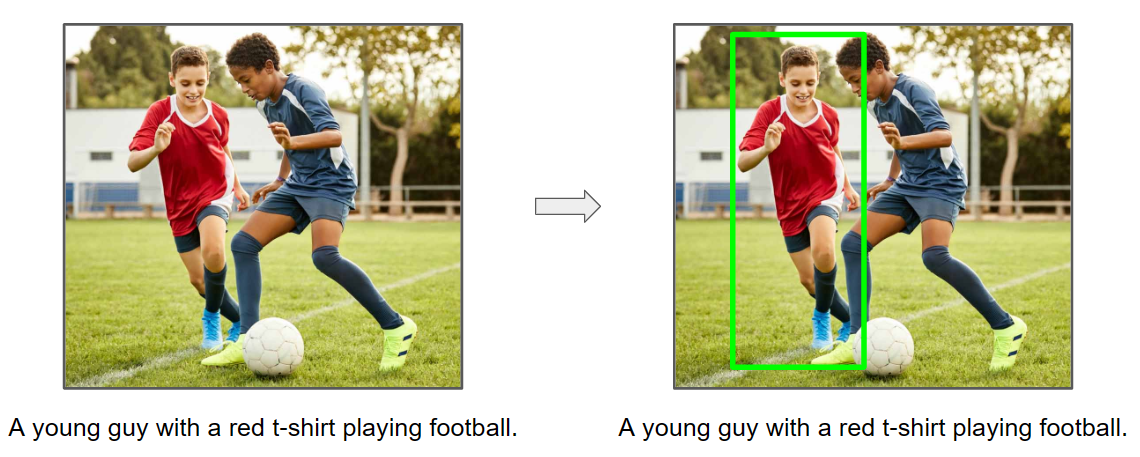

todo: forse dire che usiam Resnet 50 version of clip

In [ ]:
%%shell
tee requirements.txt << END
ftfy
jaxtyping
jupyter
matplotlib
pydantic
regex
torch
torchinfo
torchvision
tqdm
ultralytics
END

pip install -q -r requirements.txt
pip install -q git+https://github.com/openai/CLIP.git

In [ ]:
import clip
import json
import os
import pickle
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import PIL
import itertools as it
import math

from datetime import datetime
from jaxtyping import Float, UInt, Int
from pydantic.dataclasses import dataclass
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.utils import draw_bounding_boxes
from torchvision.io import read_image
from torchinfo import summary
from typing import Literal, Callable, Mapping, TypeVar
from tqdm import tqdm
from timeit import default_timer as timer
from torch.utils.tensorboard import SummaryWriter

In [ ]:
device: Literal['cpu', 'cuda'] = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.set_default_device(device)
device

#### Utils

In [ ]:
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [ ]:
# args:
#  - predictionList: [Prediction]
#  - numPred: int :: if numPred==-1 (default) consider all the predictions in predictionList
def display_predictions(predictionList, numPred=-1):
  limit = 0
  for p in predictionList:
    if numPred!=-1 and limit >= numPred:
      return;
    limit += 1

    p_image = p.image

    if(not isinstance(p_image, torch.Tensor)):
      p_image = torchvision.transforms.PILToTensor()(p_image)

    p_description = p.description
    p_ground_truth_bbox = p.ground_truth_bbox
    p_output_bbox = p.output_bbox

    # TODO: concatenate
    p_image = draw_bounding_boxes(p_image, p_ground_truth_bbox.unsqueeze(0), colors="green", width=5)
    p_image = draw_bounding_boxes(p_image, p_output_bbox.unsqueeze(0), colors="red", width=5)

    tensor_to_pil = transforms.ToPILImage()
    image_pil = tensor_to_pil(p_image)
    display(image_pil)
    print(p_description)
    print("\n\n")

## Related work

To the best of our knowledge it is not obvious to understand whether our task falls into the realm of Referring Expression Comprehension or Visual Grounding problem. Actually the two categories are very similar. According to the exhaustive survey of Yanyuan Quiao, Chaorui Deng and Qi Wu [4], visual grounding is to localize multiple object regions in an image corresponding to multiple noun phrases from a sentence that describes the underlying scene. While the goal of referring expression comprehension is to find the best matching region by the given expression.
More broadly, referring expression is normally associated with three tasks: generation, segmentation and comprehension.
* Referring expression generation (REG) aims at generating a discriminative description of an object in an image, which is very similar to the image captioning task. Different from general image captions, referring expressions are more specific about an object or region in the image [4].
* Referring expression segmentation (RES) aims to segment the referenced objects according to the referring expression [6].
* Referring expression comprehension (REC) is the reverse task of REG, which aims at localizing objects in an image based on natural language descriptions. The REC problem is typically formulated as selecting the best region from a set of region proposals extracted from the image.

Furthermore, even Object Detection resembles our objectives. However, although this latter uses predefined category labels to classify fixed objects, in our project we focus on natural language expressions to refer to objects. These phrases are more practical because they vary according to the content of images and texts, so they are more suitable for real application scenarios. Succeeding in this task is of crucial importance for other vision and language problems, such as Visual Question Answering [7][8] and Visual dialogue [9][10]. Though they have diverse model architectures, they necessitate a prior localization of the objects corresponding to a given language description or question. Notably, since the textual information is not a separate label, a simple detection method cannot meet the requirements.

More in depth, the methods to face this problem proposed by the literature over the years are divided into seven categories: joint embedding approaches, modular-based approaches, graph-based approaches, approaches using external parsers, weakly supervised approaches, one stage approaches, vision-language pre-training approaches. In this work, we focus our attention on a joint embedding approach. In essence, the main idea behind these methods is to encode the image regions and the natural language prompts into the same vector space in order to link visual and textual representations. A representative and pioneered work in this field is the one proposed by Mao et al. [11]. In this case as depicted in Figure 2, they use a Convolutional Neural Network  to generate rich image representations by embedding input images into fixed-length vectors and a LSTM network to generate text features.

By mimicking the core principles of previous joint embedding approaches, a crucial part of our solution is the representation of text and images in a shared latent space. To accomplish this, we rely on CLIP (Contrastive Language-Image Pre-training) [2], a recent large-scale model pretrained jointly on image and text data. More specifically, the architecture proposed by Radford et al., has been trained via a contrastive loss that finds a joint embedding over a set of paired image and text data. From other studies, this model has demonstrated exceptional performance on many downstream tasks. For instance, many works have fine-tuned the original model to perform zero-shot classification tasks [12][13]. In line with these approaches, in the following of the report we present our ideas to fine-tune CLIP for solving our downstream visual grounding problem.


**Figure 2**

A common apprach to solve visual grounding task using CNN-LSTM framework.

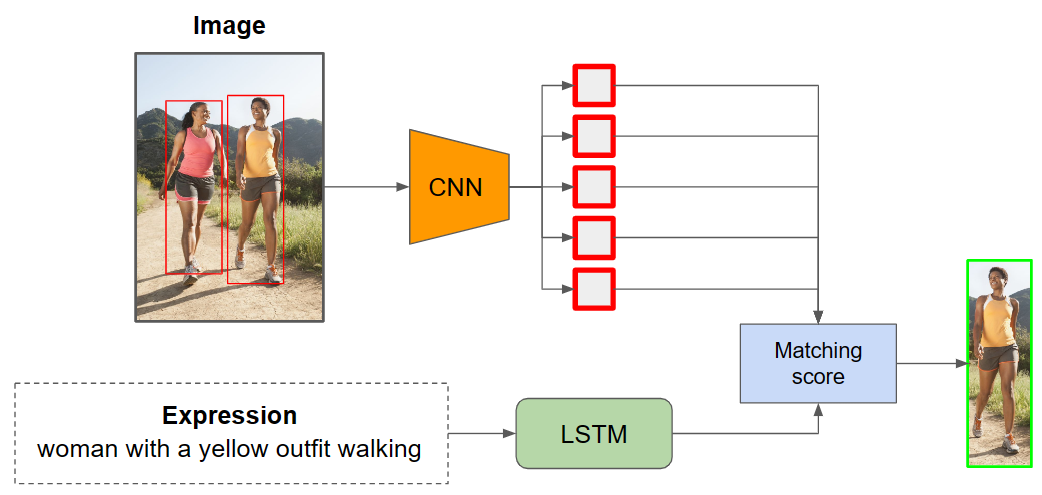

## Dataset

#### Dataset and type declaration

In [ ]:
%%shell
if ! [ -d dataset ]; then
  mkdir dataset &&
  gdown 1P8a1g76lDJ8cMIXjNDdboaRR5-HsVmUb &&
  tar -xf refcocog.tar.gz -C dataset &&
  rm refcocog.tar.gz
fi

In [ ]:
root = os.path.join("dataset", "refcocog", "")
data_instances = os.path.join(root, "annotations", "instances.json")
data_refs = os.path.join(root, "annotations", "refs(umd).p")
data_images = os.path.join(root, "images", "")

In [ ]:
I = TypeVar("I")
P = TypeVar("P")
B = TypeVar("B")
T = TypeVar("T")

Img = UInt[torch.Tensor, "C W H"]
BBox = UInt[torch.Tensor, "4"]
Split = Literal["train", "test", "val"]


@dataclass
class Info:
    description: str  # This is stable 1.0 version of the 2014 MS COCO dataset.
    url: str  # http://mscoco.org/
    version: str  # 1.0
    year: int  # 2014
    contributor: str  # Microsoft COCO group
    date_created: datetime  # 2015-01-27 09:11:52.357475


@dataclass
class Image:
    license: int  # each image has an associated licence id
    file_name: str  # file name of the image
    coco_url: str  # example http://mscoco.org/images/131074
    height: int
    width: int
    flickr_url: str  # example http://farm9.staticflickr.com/8308/7908210548_33e
    id: int  # id of the imag
    date_captured: datetime  # example '2013-11-21 01:03:06'


@dataclass
class License:
    url: str  # example http://creativecommons.org/licenses/by-nc-sa/2.0/
    id: int  # id of the licence
    name: str  # example 'Attribution-NonCommercial-ShareAlike License


@dataclass
class Annotation:
    # segmentation: list[list[float]]  # description of the mask; example [[44.17, 217.83, 36.21, 219.37, 33.64, 214.49, 31.08, 204.74, 36.47, 202.68, 44.17, 203.2]]
    area: float  # number of pixel of the described object
    iscrowd: Literal[
        1, 0
    ]  # Crowd annotations (iscrowd=1) are used to label large groups of objects (e.g. a crowd of people)
    image_id: int  # id of the target image
    bbox: tuple[
        float, float, float, float
    ]  # bounding box coordinates [xmin, ymin, width, height]
    category_id: int
    id: int  # annotation id


@dataclass
class Category:
    supercategory: str  # example 'vehicle'
    id: int  # category id
    name: str  # example 'airplane'


@dataclass
class Instances:
    info: Info
    images: list[Image]
    licenses: list[License]
    annotations: list[Annotation]
    categories: list[Category]


@dataclass
class Sentence:
    tokens: list[str]  # tokenized version of referring expression
    raw: str  # unprocessed referring expression
    sent: str  # referring expression with mild processing, lower case, spell correction, etc.
    sent_id: int  # unique referring expression id


@dataclass
class Ref:
    image_id: int  # unique image id
    split: Split
    sentences: list[Sentence]
    file_name: str  # file name of image relative to img_root
    category_id: int  # object category label
    ann_id: int  # id of object annotation in instance.json
    sent_ids: list[int]  # same ids as nested sentences[...][sent_id]
    ref_id: int  # unique id for refering expression

In [ ]:
class Prediction:
  def __init__(self, image, description, ground_truth_bbox, output_bbox):
    self.image = image
    self.description = description
    self.ground_truth_bbox = ground_truth_bbox
    self.output_bbox = output_bbox

In [ ]:
def fix_ref(x: Ref) -> Ref:
    x.file_name = fix_filename(x.file_name)
    return x


def fix_filename(x: str) -> str:
    """
    :param x: COCO_..._[image_id]_[annotation_id].jpg
    :return:  COCO_..._[image_id].jpg

    >>> fix_filename('COCO_..._[image_id]_0000000001.jpg')
    'COCO_..._[image_id].jpg'

    """
    return re.sub("_\d+\.jpg$", ".jpg", x)

In [ ]:
with open(data_refs, "rb") as f:
    raw = pickle.load(f)

refs: list[Ref] = [fix_ref(Ref(**ref)) for ref in raw]

In [ ]:
with open(data_instances, "r") as f:
    raw = json.load(f)

instances: Instances = Instances(**raw)

id2annotation: Mapping[int, Annotation] = {x.id: x for x in instances.annotations}

In [ ]:
class CocoDataset(Dataset[tuple[PIL.Image, list[str], Float[torch.Tensor, "4"]]]):
    def __init__(
        self,
        split: Split,
        limit: int = -1,
    ):
        self.__init__
        self.items: list[tuple[str, list[str], Float[torch.Tensor, "4"]]] = [
            (i, [s.sent for s in ss], xywh)
            for ref in refs
            if ref.split == split
            for i in [os.path.join(data_images, ref.file_name)]
            for ss in [ref.sentences]
            for xywh in [torch.tensor(id2annotation[ref.ann_id].bbox, dtype=torch.float)]
        ]
        self.len: int = len(self.items) if limit < 0 else min(limit, len(self.items))

    def __len__(self) -> int:
        return self.len

    def __getitem__(
        self, index: int
    ) -> tuple[PIL.Image, list[str], Float[torch.Tensor, "4"]]:
        i, ps, xywh = self.items[index]
        xyxy: Float[torch.Tensor, "4"] = torchvision.ops.box_convert(xywh, in_fmt="xywh", out_fmt="xyxy")
        with PIL.Image.open(i) as img:
            img.load()
            return img, ps, xyxy

In [ ]:
class Coco4CLIPDataset(Dataset[tuple[list[PIL.Image], list[str]]]):
    def __init__(
        self,
        split: Split,
        limit: int = -1,
    ):
        self.__init__
        self.items: list[tuple[str, list[str], Float[torch.Tensor, "4"]]] = [
            (i, [s.sent for s in ss], xywh)
            for ref in refs
            if ref.split == split
            for i in [os.path.join(data_images, ref.file_name)]
            for ss in [ref.sentences]
            for xywh in [torch.tensor(id2annotation[ref.ann_id].bbox, dtype=torch.float)]
        ]
        self.len: int = len(self.items) if limit < 0 else min(limit, len(self.items))

    def __len__(self) -> int:
        return self.len

    def __getitem__(self, index: int) -> tuple[list[PIL.Image], list[str]]:
        i, ps, xywh = self.items[index]
        xyxy: Float[torch.Tensor, "4"] = torchvision.ops.box_convert(xywh, in_fmt="xywh", out_fmt="xyxy")
        with PIL.Image.open(i) as img:
            img.load()
            return [img.crop(xyxy.tolist())], ps

In [ ]:
def unzip(batch: list[tuple[T, ...]]) -> tuple[list[T], ...]:
    return tuple(zip(*batch))

In [ ]:
batch_size: int = 3
limit: int = 5 * batch_size

In [ ]:
dl: DataLoader[tuple[list[PIL.Image], list[list[str]], list[Float[torch.Tensor, "4"]]]] = DataLoader(
    dataset=CocoDataset(split="test", limit=limit),
    batch_size=batch_size,
    collate_fn=unzip,
)

In [ ]:
dl4clip: DataLoader[tuple[list[PIL.Image], list[str]]] = DataLoader(
    dataset=Coco4CLIPDataset(split="test", limit=limit),
    batch_size=batch_size,
    collate_fn=unzip,
    shuffle=True,
)

In [ ]:
imgs: tuple[PIL.Image, ...]
promptss: tuple[list[str], ...]
true_xyxy: tuple[Float[torch.Tensor, "4"], ...]

for imgs, promptss, true_xyxy in dl:
    print(imgs)
    print(promptss)
    print(true_xyxy)
    print("-" * 50)

In [ ]:
cropss: tuple[list[PIL.Image], ...]
promptss: tuple[list[str], ...]

for cropss, promptss in dl4clip:
    print(cropss)
    print(promptss)
    print("-" * 50)

## Evaluation metrics

Recent works [12][13] have shown that even subtle changes in the finetuning process can lead to surprisingly large differences in the final performance. In order to provide valuable comparisons between our solution proposals and to ensure that the implemented models are performing as intended, it is essential to evaluate them according to appropriate metrics. With the aim of quantitatively measure the capabilities of our algorithms, we have considered the following criteria.

### Localization accuracy

Localization accuracy (Formula 1) measures how accurately the fine-tuned network can ground the localized object to a language description. Intersection over Union (IoU) is a common measure of localization accuracy (Figure 3). In particular, we keep track of:
*   mean intersection over union (**mIoU**)
*   the fraction of correct predictions with respect to the total number of processed samples, considering an IoU threshold of 0.3 (**mA [IoU .3]**). That is, the predicted bounding box cap{b} is considered correct if the IoU between cap{b} and the ground-truth bounding box b is at least 30%.
* the fraction of correct predictions with respect to the total number of processed samples, considering an IoU threshold of 0.5 (**mA [IoU .5]**)
* the fraction of correct predictions with respect to the total number of processed samples, considering an IoU threshold of 0.7 (**mA [IoU .7]**)

### Semantic similarity

Semantic similarity (Formula 2) measures the similarity between the predicted bounding box $\hat{b}$ and the portion of the image which corresponds to the ground-truth bounding box $b$. Consider the output proposed in Figure 4. The neural network predicts the red bounding box $\hat{b}$ while in the dataset the green bounding box $b$ is the annotated ground-truth. Evidently, the algorithm response does not represent a true mistake. Conceptually, the two portions of the picture delimited by $\hat{b}$ and $b$ are semantically equivalent. For the purpose of computing the semantic similarity between two crops we evaluate the mean cosine similarity (**mCos**) and the mean euclidean distance (**mED**) between the $\hat{b}_z$s and the $b_z$s which are the latent space representations of the predicted bounding boxes $\hat{b}_z$s and the ground-truth bounding boxes $b$s respectively. In order to achieve a fair comparison, we consistently use the original CLIP visual encoder (`encode_image()` method) to geometrically represent a cropped portion of the image with a vector of size 1024 (Figure 5).

**Formula 1**

$d(b_z, \hat{b}_z) = ||b_z - \hat{b}||$

**Formula 2**

$S_C(b_z, \hat{b}_z) = \frac{b_z \cdot \hat{b}_z}{\lVert{} b_z \rVert{} \lVert{}\hat{b}_z\rVert{}} = \frac{\sum_{i=1}^{n}b_{z_i}\hat{b}_{z_i}}{\sqrt{\sum_{i=1}^{n}b_{z_i}^2 \cdot \sum_{i=1}^{n}\hat{b}_{z_i}^2}}$

**Figure 3**

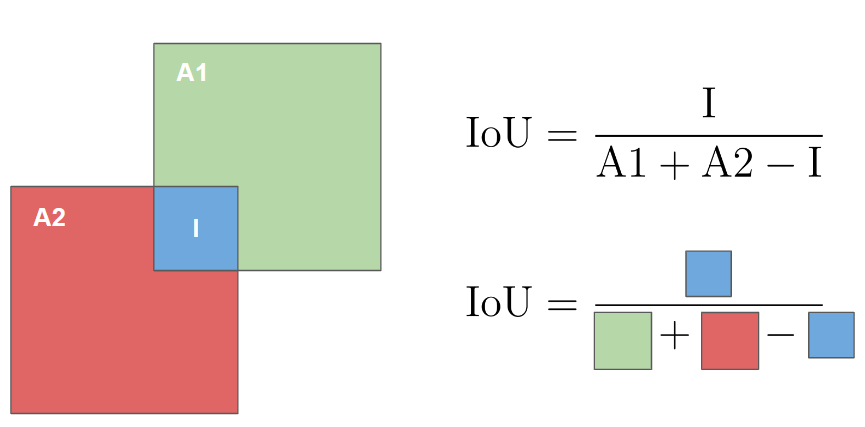

**Figure 4**

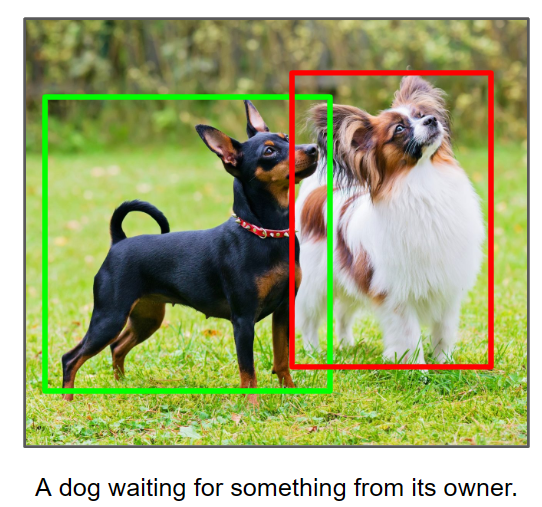

**Figure 5**

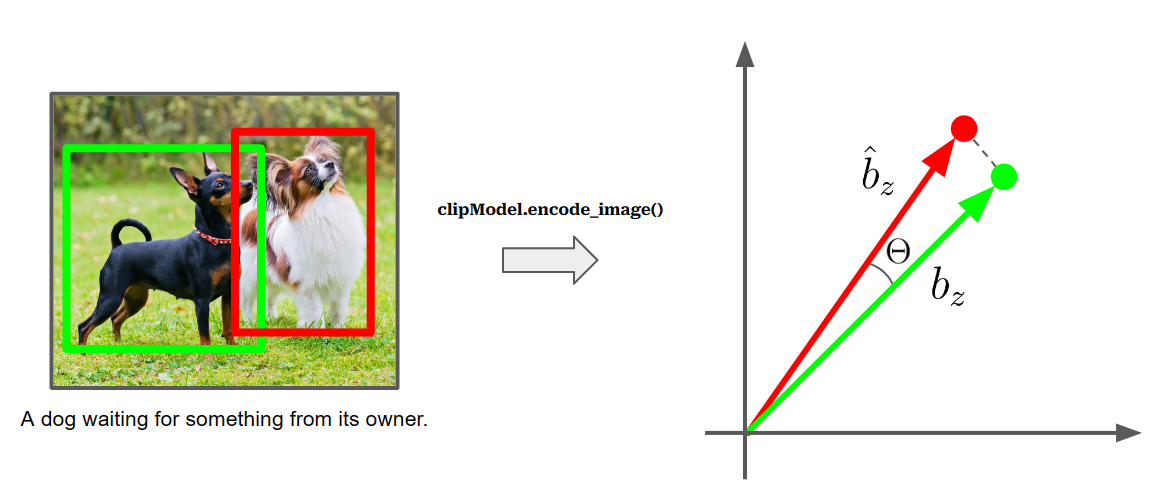

## Baseline

## Region proposal algorithms

## Standard fine-tuning

## Fine-tune like you pretrain

## Exploiting self-attention to provide contextualized latent space representations

## Strategies to improve model generalization

### Regularization techniques

### Hyperparameter tuning

### Data augmentation (forse: and noise injection)

## Conclusion and further research directions

## References

[[1]](https://www.cs.utexas.edu/users/ai-lab/downloadPublication.php?filename=http://www.cs.utexas.edu/users/ml/papers/thomason.robonlp17.pdf&pubid=127642)  Jesse Thomason, Jivko Sinapov, and Raymond Mooney,
"Guiding interaction behaviors for multi-modal grounded language learning," in Proceedings of the First Workshop on Language Grounding for Robotics, 2017

[[2]](https://arxiv.org/abs/2103.00020) Alec Radford, Jong Wook Kim, Chris Hallacy, Aditya Ramesh, Gabriel Goh Sandhini Agarwal, Girish Sastry, Amanda Askell, Pamela Mishkin, Jack Clark, et al. Learning transferable visual models from natural language supervision. In International conference on machine learning, pages 8748-8763. PMLR, 2021.

[[3]](https://arxiv.org/abs/1608.00272) Licheng Yu, Patrick Poirson, Shan Yang, Alexander C Berg, and Tamara L Berg. Modeling context in referring expressions. In Computer Vision-ECCV 2016: 14th European Conference, Amsterdam, The Netherlands, October 11-14, 2016, Proceedings, Part II 14, pages 69-85. Springer, 2016.


[[4]](https://arxiv.org/abs/2007.09554) Yanyuan Qiao and Chaorui Deng and Qi Wu. Referring Expression Comprehension: A Survey of Methods and Datasets. Year 2020.

[[5]](https://arxiv.org/abs/2212.00638) Sachin Goyal and Ananya Kumar and Sankalp Garg and Zico Kolter and Aditi Raghunathan. Finetune like you pretrain: Improved finetuning of zero-shot vision models. Year 2022.

[[6]](https://ieeexplore.ieee.org/document/8845685) S. Qiu, Y. Zhao, J. Jiao, Y. Wei, and S. Wei, "Referring image segmentation by generative adversarial learning", IEEE Trans. Multimedia. Year 2020.

[[7]](https://arxiv.org/abs/1505.00468) S. Antol, A. Agrawal, J. Lu, M. Mitchell, D. Batra, C. Lawrence Zitnick,
and D. Parikh, "Vqa: Visual question answering", in Proc. IEEE Int.
Conf. Comput. Vis. Year 2015.

[[8]](https://ieeexplore.ieee.org/document/9422035) Q. Wu, D. Teney, P. Wang, C. Shen, A. Dick, and A. van den Hengel, "Visual question answering: A survey of methods and datasets" Comput.
Vis. Image Underst. Year 2017.

[[9]](https://arxiv.org/abs/1904.05548) Z. Zheng, W. Wang, S. Qi, and S. Zhu, "Reasoning visual dialogs with structural and partial observations" in Proc. IEEE Conf. Comput. Vis.
Pattern Recognit. Year 2019.

[[10]](https://arxiv.org/abs/1809.01816) S. Kottur, J. M. F. Moura, D. Parikh, D. Batra, and M. Rohrbach, "Visual coreference resolution in visual dialog using neural module networks",
in Proc. Eur. Conf. Comput. Vis. Year 2018.

[[11]](https://arxiv.org/abs/1511.02283) J. Mao, J. Huang, A. Toshev, O. Camburu, A. L. Yuille, and K. Murphy, "Generation and comprehension of unambiguous object descriptions", in
Proc. IEEE Conf. Comput. Vis. Pattern Recognit. Year 2016.

[[12]](https://arxiv.org/abs/2202.10054) Ananya Kumar, Aditi Raghunathan, Robbie Matthew Jones, Tengyu Ma, and Percy Liang. "Fine-tuning can distort
pretrained features and underperform out-of-distribution". In International Conference on Learning Representations
(ICLR). Year 2022.

[[13]](https://arxiv.org/abs/2109.01903) Mitchell Wortsman, Gabriel Ilharco, Mike Li, Jong Wook Kim, Hannaneh Hajishirzi, Ali Farhadi, Hongseok
Namkoong, and Ludwig Schmidt. Robust fine-tuning of zero-shot models.CoRR. Year 2021.